# Pure Premium Prediction

### Introduction

The most common types of ratemaking models in the insurance industry are frequency, severity, and pure premium
models. Frequency models predict how often claims are made, and severity models predict claim amounts. The term
pure premium is unique to insurance; it is the portion of the company’s expected cost that is “purely” attributed to loss. Pure premium does not include the general expense of doing business, such as overhead and commissions. Traditionally, the Tweedie distribution is used to model pure premium in a generalized linear model framework (GLM).

XGBoost has become incredibly popular on Kaggle in the last year for any problems dealing with structured data and accuracy predictions. Random forest was also incredibly popular on Kaggle few years ago. Let's play with both models using insurance data to model the pure premium.

### Dataset description

- Dataset used in this code: `claim_history.csv`
- The `claim_history.csv` dataset comes from the help library of SAS Enterprise-Miner version 7.1
- Data description: 
    - observations: 10302
    - Variables: 27

Variable description:
    
|#	|Variable	|Label                            |
|---|-----------|---------------------------------|
|1	|ID	        |Identification#                  |
|2	|KIDSDRIV	|#Driving Children                |
|3	|BIRTH	    |Date of Birth                    | 
|4	|AGE	    |Age               
|5	|HOMEKIDS	|#Children @Home
|6	|YOJ	    |Years on Job
|7	|INCOME	    |Income
|8	|PARENT1	|Single Parent
|9	|HOME_VAL	|Home Value
|10	|MSTATUS	|Marital Status
|11	|GENDER	    |Driver Gender
|12	|EDUCATION	|Max Education Level
|13	|OCCUPATION	|Driver Occupation
|14	|TRAVTIME	|Distance to Work
|15	|CAR_USE	|Vehicle Use
|16	|BLUEBOOK	|Value of Vehicle
|17	|TIF	    |Time in Force
|18	|CAR_TYPE	|Type of Car
|19	|RED_CAR	|A Red Car
|20	|OLDCLAIM	|Total Claims(Past 5 Years)
|21	|CLM_FREQ	|#Claims(Past 5 Years)
|22	|REVOKED	|License Revoked (Past 7 Years)
|23	|MVR_PTS	|Motor Vehicle Record Points
|24	|CLM_AMT	|Claim Amount
|25	|CAR_AGE	|Vehicle Age
|26	|CLAIM_FLAG	|Claim Indicator
|27	|URBANICITY	|Home/Work Area

### Getting and Preprocessing the Data

1. Load packages and data
2. Drop unuseful features
3. Treatment of missing observations
4. Transform some features from continuous to categorical
5. Transform some categorical features into dummy variables
6. Clean some new features names
7. Scaling target variables
8. Splitting the data into training, testing, and validation sets

##### Load packages and data

First load the needed packages:

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import scipy as scipy
import pylab as pylab
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Next, load the CSV file as a Pandas data frame:

In [5]:
claims = pd.read_csv('claim_history.csv')

Let's take a look to the data:

In [4]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
ID            10302 non-null int64
KIDSDRIV      10302 non-null int64
BIRTH         10302 non-null object
AGE           10295 non-null float64
HOMEKIDS      10302 non-null int64
YOJ           9754 non-null float64
INCOME        9732 non-null object
PARENT1       10302 non-null object
HOME_VAL      9727 non-null object
MSTATUS       10302 non-null object
GENDER        10302 non-null object
EDUCATION     10302 non-null object
OCCUPATION    9637 non-null object
TRAVTIME      10302 non-null int64
CAR_USE       10302 non-null object
BLUEBOOK      10302 non-null object
TIF           10302 non-null int64
CAR_TYPE      10302 non-null object
RED_CAR       10302 non-null object
OLDCLAIM      10302 non-null object
CLM_FREQ      10302 non-null int64
REVOKED       10302 non-null object
MVR_PTS       10302 non-null int64
CLM_AMT       10302 non-null object
CAR_AGE       9663 non-null float64


There are 47 columns. The target variable is 'CLM_AMT'. Let's go deeper into the data:

In [5]:
claims.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


##### Convert some features from currency to float

Now it is clear that some interval features such 'INCOME' or 'HOME_VAL' have a currency format. Therefore, we need to convert currency to float:

In [6]:
# From currency to float
for field in ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']:
    claims.loc[:,field] = claims[field] = (claims[field].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

##### Drop unuseful features

There are some variables that are unuseful in this context, we can drop them:

In [7]:
claims = claims.drop(['ID','BIRTH','CLAIM_FLAG'], axis=1)

##### Treatment of missing observations

Let's take a look to the missing observations:

In [8]:
claims.isnull().sum()

KIDSDRIV        0
AGE             7
HOMEKIDS        0
YOJ           548
INCOME        570
PARENT1         0
HOME_VAL      575
MSTATUS         0
GENDER          0
EDUCATION       0
OCCUPATION    665
TRAVTIME        0
CAR_USE         0
BLUEBOOK        0
TIF             0
CAR_TYPE        0
RED_CAR         0
OLDCLAIM        0
CLM_FREQ        0
REVOKED         0
MVR_PTS         0
CLM_AMT         0
CAR_AGE       639
URBANICITY      0
dtype: int64

There are some variables with few missing observations. The features 'YOJ','INCOME', 'HOME_VAL' and 'CAR_AGE' are interval features, it is easy to replace the missed observations with the mean of the variable:

In [9]:
# Inputation for interval features
for field in ['AGE','YOJ','INCOME','HOME_VAL','CAR_AGE']:
    claims.loc[:,field] = claims.fillna(claims.mean()[field])

the 'OCCUPATION' column is categorical. In order to fill NaNs with the most frequent value from the categorical 'OCCUPATION' column:

In [10]:
claims = claims.fillna(claims['OCCUPATION'].value_counts().index[0])

##### Transform some features from continuous to categorical

The following features 'KIDSDRIV', 'HOMEKIDS' and 'CLM_FREQ' are continuous in our dataset. We need to convert this variables into a string type because has no sense to treat these variables as continuous:

In [11]:
claims[['KIDSDRIV','HOMEKIDS','CLM_FREQ']] = claims[['KIDSDRIV','HOMEKIDS','CLM_FREQ']].astype(str)

##### Transform some categorical features into dummy variables

Here we have some categorical variables like 'KIDSDRIV' or 'CAR_TYPE'. To include these in our model, we'll need to make dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [12]:
dummy_fields = ['KIDSDRIV','HOMEKIDS','PARENT1','MSTATUS','GENDER','EDUCATION',\
                'OCCUPATION','CAR_USE','CAR_TYPE','RED_CAR','CLM_FREQ','REVOKED',\
                'URBANICITY']
for each in dummy_fields:
    dummies = pd.get_dummies(claims[each], prefix=each, drop_first=False)
    claims = pd.concat([claims, dummies], axis=1)

fields_to_drop = ['KIDSDRIV','HOMEKIDS','PARENT1','MSTATUS','GENDER','EDUCATION',\
                  'OCCUPATION','CAR_USE','CAR_TYPE','RED_CAR','CLM_FREQ','REVOKED',\
                  'URBANICITY']
claims = claims.drop(fields_to_drop, axis=1)

Let's check how many variables we have now:

In [13]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 61 columns):
AGE                                 10302 non-null float64
YOJ                                 10302 non-null float64
INCOME                              10302 non-null float64
HOME_VAL                            10302 non-null float64
TRAVTIME                            10302 non-null int64
BLUEBOOK                            10302 non-null float64
TIF                                 10302 non-null int64
OLDCLAIM                            10302 non-null float64
MVR_PTS                             10302 non-null int64
CLM_AMT                             10302 non-null float64
CAR_AGE                             10302 non-null float64
KIDSDRIV_0                          10302 non-null uint8
KIDSDRIV_1                          10302 non-null uint8
KIDSDRIV_2                          10302 non-null uint8
KIDSDRIV_3                          10302 non-null uint8
KIDSDRIV_4          

Now we have 61 variables in our dataset.

##### Clean some new features names

The 'XGBoost' and the random forest algorithms don't admit special symbols in the feature names such as '<','/' or ','. Therefore, we need to rename those feature names:

In [14]:
claims = claims.rename(columns={'EDUCATION_<High School': 'EDUCATION_lt_High_School', 
                        'OCCUPATION_z_Blue Collar': 'OCCUPATION_z_Blue_Collar',
                        'CAR_TYPE_Panel Truck': 'CAR_TYPE_Panel_Truck',
                        'CAR_TYPE_Sports Car': 'CAR_TYPE_Sports_Car',
                        'URBANICITY_Highly Urban/ Urban': 'URBANICITY_Urban',
                        'URBANICITY_z_Highly Rural/ Rural': 'URBANICITY_Rural'})

In [15]:
plot_clm_amt = claims['CLM_AMT']

##### Scaling target variables

To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [16]:
quant_features = ['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 
                  'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT', 'CAR_AGE']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = claims[each].mean(), claims[each].std()
    scaled_features[each] = [mean, std]
    claims.loc[:, each] = (claims[each] - mean)/std

##### Splitting the data into training, testing, and validation sets
We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [17]:
# Split off random 50% of the data for training, 25% for testing and 25% for validation
np.random.seed(21)
sample = np.random.choice(claims.index, size=int(len(claims)*0.5), replace=False)
data, train = claims.ix[sample], claims.drop(sample)

sample = np.random.choice(data.index, size=int(len(data)*0.5), replace=False)
val, test = data.ix[sample], data.drop(sample)

# Split into features and targets
features, targets = train.drop('CLM_AMT', axis=1), train['CLM_AMT']
features_val, targets_val = val.drop('CLM_AMT', axis=1), val['CLM_AMT']
features_test, targets_test = test.drop('CLM_AMT', axis=1), test['CLM_AMT']

With this we've finished the data preparation tasks, we are ready to use XGBoost and random forest.

### Fitting the model

##### Fitting the model
Let's fit the XGBoost and the random forest to the data:

In [18]:
# fit XGBoost model to training data
xgb_model = XGBRegressor()
xgb_model.fit(features, targets)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [19]:
# fit random forest to training data
rf_model = RandomForestRegressor(200)
rf_model.fit(features, targets)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

##### Make predictions for the test data

We are now ready to use the trained model to make predictions. We can make predictions using the fit model on the test dataset. To make predictions we use the `scikit-learn` function `model.predict()`.

In [20]:
# make predictions for test data using XGBoost
y_pred_xgb = xgb_model.predict(features_test)
#predictions = [round(value ,2) for value in y_pred]

In [21]:
# make predictions for test data using random forest
y_pred_rf = rf_model.predict(features_test)
#predictions = [round(value ,2) for value in y_pred]

##### Evaluate model performance

Now that we have used the fit model to make predictions on new data, we can evaluate the performance of the predictions by comparing them to the expected values. For this we will use the built in `mean_absolute_error` function in scikit-learn.

In [22]:
# evaluate predictions using XGBoost
score = mean_absolute_error(targets_test, y_pred_xgb)
print("XGBoost Score: %.4f" % score)

XGBoost Score: 0.4036


In [23]:
# evaluate predictions using random forest
score = mean_absolute_error(targets_test, y_pred_rf)
print("Random forest Score: %.4f" % score)

Random forest Score: 0.4297


It is clear that the XGBoost fits the data better than the random forest. The absolute mean error is lower for the XGBoost. Let's go deeper and create a lift chart to compare the model performance from another point of view.

##### Create a lift chart to compere model performance

A classical chart used to compere regressions models (also classification) is a Lift chart. Let's create both lift charts.

In [24]:
def gini(actual,pred,weight=None):
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort_values('Predicted')
    if weight is None:
        pdf['Weight'] = 1.0
  
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    return Gini 

In [25]:
gini(targets_test,y_pred_xgb,weight=None)

-13.489679386152188

In [26]:
gini(targets_test,y_pred_rf,weight=None)

-13.082823959818159

In [27]:
def mylift(actual,pred,weight=None,n=10,xlab='Predicted Decile',MyTitle='Model Performance Lift Chart'):
    pdf= pd.DataFrame(scipy.vstack([actual,pred]).T,columns=['Actual','Predicted'],)
    pdf= pdf.sort(columns='Predicted')
    if weight is None:
        pdf['Weight'] = 1.0
  
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    NormalizedGini = Gini/ gini(pdf['Actual'],pdf['Actual'])
    GiniTitle = 'Normalized Gini = '+ str(round(NormalizedGini,4))
    
    pdf['PredictedDecile'] = np.round(pdf['CummulativeWeight']*n /TotalWeight + 0.5,decimals=0)
    pdf['PredictedDecile'][pdf['PredictedDecile'] < 1.0] = 1.0
    pdf['PredictedDecile'][pdf['PredictedDecile'] > n] = n 
    
    pdf['WeightedPrediction'] = pdf['Predicted']*pdf['Weight']
    pdf['WeightedActual'] = pdf['Actual']*pdf['Weight']
    lift_df = pdf.groupby('PredictedDecile').agg({'WeightedPrediction': np.sum,'Weight':np.sum,'WeightedActual':np.sum,'PredictedDecile':np.size})
    nms = lift_df.columns.values
    nms[1] = 'Count'
    lift_df.columns = nms
    lift_df['AveragePrediction'] = lift_df['WeightedPrediction']/lift_df['Weight']
    lift_df['AverageActual'] = lift_df['WeightedActual']/lift_df['Weight']
    lift_df['AverageError'] = lift_df['AverageActual']/lift_df['AveragePrediction']
    
    d = pd.DataFrame(lift_df.index)
    p = lift_df['AveragePrediction']
    a = lift_df['AverageActual']
    pylab.plot(d,p,label='Predicted',color='blue',marker='o')
    pylab.plot(d,a,label='Actual',color='red',marker='d')
    pylab.legend(['Predicted','Actual'], loc=2)
    pylab.title(MyTitle +'\n'+GiniTitle)
    pylab.xlabel(xlab)
    pylab.ylabel('Actual vs. Predicted')
    pylab.grid()
    pylab.show()

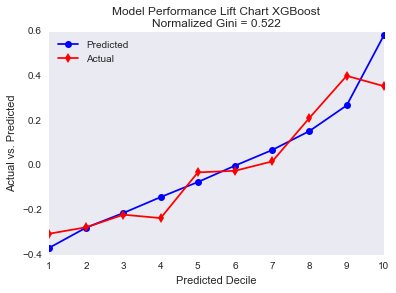

In [28]:
mylift(targets_test,y_pred_xgb,weight=None,n=10,xlab='Predicted Decile',\
       MyTitle='Model Performance Lift Chart XGBoost')

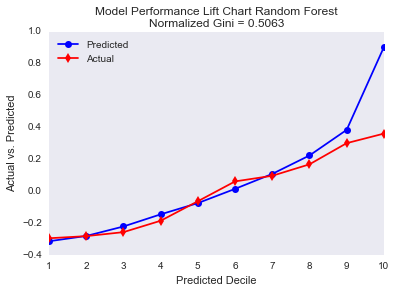

In [29]:
mylift(targets_test,y_pred_rf,weight=None,n=10,xlab='Predicted Decile',\
       MyTitle='Model Performance Lift Chart Random Forest')

Although the random forest fits the data better than the XGBoost for the first nine percentiles, the XGBoost fits much better the tenth percentile. This is interesting because fitting a risk premium model is quite difficult because the great majority of the policies has no claim and therefore, the loss is zero as you can see in this image:

<img src="images/tweedie.png?raw=true" alt="HTML5 Icon" style="width:500px;">

The policies with positive claims are in the tenth decile. The random forest performs really bad for the policies with positive claims. 

Here we can see the distribution of the risk premium in our dataset:

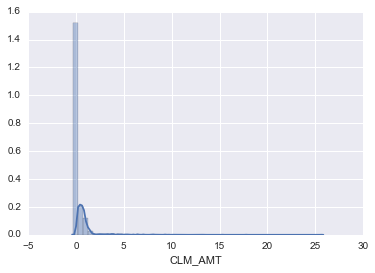

In [32]:
sns.distplot(plot_clm_amt)